<h1>PREDICTING THE PLANETARY RADIUS OF EXOPLANETS AND FINDING POTENTIAL EXOPLANETS</h1>

In [1]:
# imporitng required packages
from pandas import read_csv, concat, DataFrame
from numpy import sqrt, polyfit, poly1d
from seaborn import heatmap, countplot, set, histplot, boxplot
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# reading file into dataframe
df = read_csv('nasa_exoplanets.csv', skiprows=53)

In [3]:
# displaying the head of the dataframe
df.head()

,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,K00752.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,9.488036,2.775000e-05,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,K00752.02,CONFIRMED,CANDIDATE,0.969,0,0,0,0,54.418383,2.479000e-04,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,K00753.01,CANDIDATE,CANDIDATE,0.000,0,0,0,0,19.899140,1.494000e-05,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,1.736952,2.630000e-07,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,K00755.01,CONFIRMED,CANDIDATE,1.000,0,0,0,0,2.525592,3.761000e-06,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


<h1>Data Cleaning and Transformation</h1>

<h3>removing excess columns</h3>

In [4]:
# shape of the dataframe before cleaning process
df.shape

(9564, 47)

In [5]:
# removing columns which are not needed for our model
# most of these columns are which have same value in negatives since error is stored on both sides, so we removed one side
cols_to_drop= ['koi_period_err1','koi_time0bk_err1','koi_impact_err1','koi_duration_err1','koi_depth_err1',
               'koi_depth_err2','koi_prad_err2','koi_teq_err1','koi_teq_err2','koi_insol_err1',
               'koi_insol_err2','koi_steff_err1','koi_steff_err2','koi_slogg_err1','koi_slogg_err2',
               'koi_srad_err1','koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec', 'koi_tce_delivname']

df.drop(columns=cols_to_drop, inplace=True)
df.head()

,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_period_err2,koi_time0bk,koi_time0bk_err2,koi_impact,koi_impact_err2,...,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,koi_srad_err2,ra,dec,koi_kepmag
0,K00752.01,CONFIRMED,CANDIDATE,1.000,9.488036,-2.775000e-05,170.538750,-0.002160,0.146,-0.146,...,93.59,35.8,1.0,5455.0,4.467,0.927,-0.061,291.93423,48.141651,15.347
1,K00752.02,CONFIRMED,CANDIDATE,0.969,54.418383,-2.479000e-04,162.513840,-0.003520,0.586,-0.443,...,9.11,25.8,2.0,5455.0,4.467,0.927,-0.061,291.93423,48.141651,15.347
2,K00753.01,CANDIDATE,CANDIDATE,0.000,19.899140,-1.494000e-05,175.850252,-0.000581,0.969,-0.077,...,39.30,76.3,1.0,5853.0,4.544,0.868,-0.078,297.00482,48.134129,15.436
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,1.736952,-2.630000e-07,170.307565,-0.000115,1.276,-0.092,...,891.96,505.6,1.0,5805.0,4.564,0.791,-0.067,285.53461,48.285210,15.597
4,K00755.01,CONFIRMED,CANDIDATE,1.000,2.525592,-3.761000e-06,171.595550,-0.001130,0.701,-0.478,...,926.16,40.9,1.0,6031.0,4.438,1.046,-0.133,288.75488,48.226200,15.509


In [6]:
# shape of the dataframe after removing unnecessary columns
df.shape

(9564, 26)

<h3>removing rows where target value is missing</h3>

In [7]:
# removing rows where the target value is missing
df.dropna(subset=['koi_prad'], inplace=True)

In [8]:
# shape after removing rows where target value is missing
df.shape

(9201, 26)

<h3>Filling missing values</h3>

In [9]:
# checking the Nan values in all the columns in the dataframe before filling them
df.isna().sum()

kepoi_name              0
koi_disposition         0
koi_pdisposition        0
koi_score            1206
koi_period              0
koi_period_err2        91
koi_time0bk             0
koi_time0bk_err2       91
koi_impact              0
koi_impact_err2        91
koi_duration            0
koi_duration_err2      91
koi_depth               0
koi_prad                0
koi_prad_err1           0
koi_teq                 0
koi_insol               0
koi_model_snr           0
koi_tce_plnt_num      255
koi_steff               0
koi_slogg               0
koi_srad                0
koi_srad_err2         105
ra                      0
dec                     0
koi_kepmag              1
dtype: int64

In [10]:
# checking the Nan values in all columns, if there are any then we replace the Nan values with mean of that column
for i in df.columns:
    if df.isna().sum()[i] != 0:
        df[i].fillna(df[i].mean(), inplace=True) 

In [11]:
# checking the Nan values in all the columns in the dataframe after filling them
# we can see that there are 0 Nan values in all the columns in the dataframe
df.isna().sum()

kepoi_name           0
koi_disposition      0
koi_pdisposition     0
koi_score            0
koi_period           0
koi_period_err2      0
koi_time0bk          0
koi_time0bk_err2     0
koi_impact           0
koi_impact_err2      0
koi_duration         0
koi_duration_err2    0
koi_depth            0
koi_prad             0
koi_prad_err1        0
koi_teq              0
koi_insol            0
koi_model_snr        0
koi_tce_plnt_num     0
koi_steff            0
koi_slogg            0
koi_srad             0
koi_srad_err2        0
ra                   0
dec                  0
koi_kepmag           0
dtype: int64

In [12]:
# Moving target column to the right most side of the dataframe for easy access

# storing koi_prad column into a temporary variable
koi_prad = df['koi_prad'].tolist()

# dropping column from the dataframe
df.drop(columns=['koi_prad'], inplace=True)

# adding at the end
df['koi_prad'] = koi_prad

# This will now have 'koi_prad' as the last column in the DataFrame
df.head()

,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_period_err2,koi_time0bk,koi_time0bk_err2,koi_impact,koi_impact_err2,...,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,koi_srad_err2,ra,dec,koi_kepmag,koi_prad
0,K00752.01,CONFIRMED,CANDIDATE,1.000,9.488036,-2.775000e-05,170.538750,-0.002160,0.146,-0.146,...,35.8,1.0,5455.0,4.467,0.927,-0.061,291.93423,48.141651,15.347,2.26
1,K00752.02,CONFIRMED,CANDIDATE,0.969,54.418383,-2.479000e-04,162.513840,-0.003520,0.586,-0.443,...,25.8,2.0,5455.0,4.467,0.927,-0.061,291.93423,48.141651,15.347,2.83
2,K00753.01,CANDIDATE,CANDIDATE,0.000,19.899140,-1.494000e-05,175.850252,-0.000581,0.969,-0.077,...,76.3,1.0,5853.0,4.544,0.868,-0.078,297.00482,48.134129,15.436,14.60
3,K00754.01,FALSE POSITIVE,FALSE POSITIVE,0.000,1.736952,-2.630000e-07,170.307565,-0.000115,1.276,-0.092,...,505.6,1.0,5805.0,4.564,0.791,-0.067,285.53461,48.285210,15.597,33.46
4,K00755.01,CONFIRMED,CANDIDATE,1.000,2.525592,-3.761000e-06,171.595550,-0.001130,0.701,-0.478,...,40.9,1.0,6031.0,4.438,1.046,-0.133,288.75488,48.226200,15.509,2.75


<h3>Removing outliers</h3>

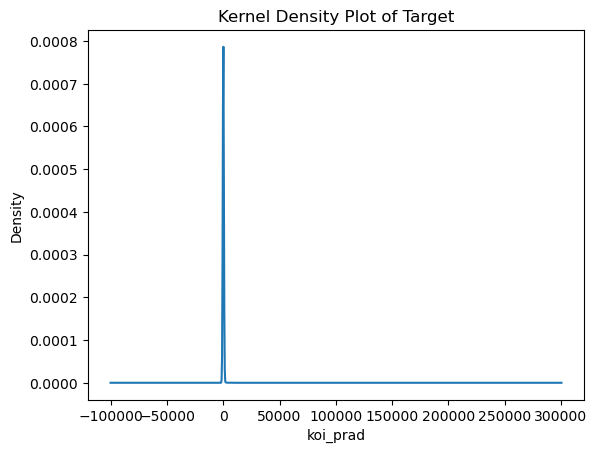

In [13]:
# density plot before removing outliers
df['koi_prad'].plot.kde()
plt.xlabel('koi_prad')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Target')
plt.show()

In [14]:
def remove_outliers_iqr(df, numerical_column, val):
    """
    Removes outliers from a DataFrame using the Interquartile Range (IQR) method.

    Args:
    - df: DataFrame containing the data
    - numerical_column: Name of the numerical column to remove outliers from
    - val: Value to calculate quantiles (e.g., 0.25 for Q1 and 0.75 for Q3)

    Returns:
    - df_no_outliers: DataFrame without the outliers based on the specified column
    """
    Q1 = df[numerical_column].quantile(val)
    Q3 = df[numerical_column].quantile(1-val)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1 * IQR

    df_no_outliers = df[(df[numerical_column] >= lower_bound) & (df[numerical_column] <= upper_bound)]

    return df_no_outliers

In [15]:
# removing outliers from the dataframe
df = remove_outliers_iqr(df, 'koi_prad', 0.37) 

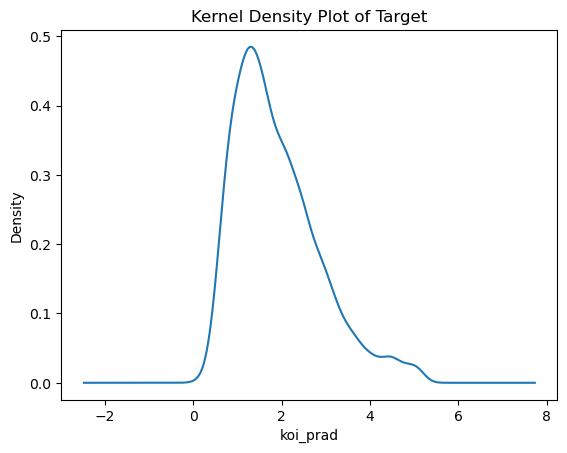

In [16]:
# density plot before removing outliers
df['koi_prad'].plot.kde()
plt.xlabel('koi_prad')
plt.ylabel('Density')
plt.title('Kernel Density Plot of Target')
plt.show()

We can clearly see that before removing outliers the distribution was concentrated at 0. While the range was spread more than 200,000. But after removing the outliers we can see that it is spread wider than before

In [17]:
# shape of the dataframe after cleaning and transformation
df.shape

(6238, 26)

In [18]:
# storing cleaned dataframe into 
df.to_csv('cleaned_exoplanets.csv', index=False)

<h1>Exploratory Data Analysis (EDA)</h1>

In [19]:
# exploring the datatypes of the columns of dataframe
df.dtypes

kepoi_name            object
koi_disposition       object
koi_pdisposition      object
koi_score            float64
koi_period           float64
koi_period_err2      float64
koi_time0bk          float64
koi_time0bk_err2     float64
koi_impact           float64
koi_impact_err2      float64
koi_duration         float64
koi_duration_err2    float64
koi_depth            float64
koi_prad_err1        float64
koi_teq              float64
koi_insol            float64
koi_model_snr        float64
koi_tce_plnt_num     float64
koi_steff            float64
koi_slogg            float64
koi_srad             float64
koi_srad_err2        float64
ra                   float64
dec                  float64
koi_kepmag           float64
koi_prad             float64
dtype: object

From the above result we can see that there are only three object datatype rows which are not useful for machine learning model. So we can use the remaining 23 columns for our regression model. 

In [20]:
# Generating descriptive statistics of the dataframe
df.describe()

,koi_score,koi_period,koi_period_err2,koi_time0bk,koi_time0bk_err2,koi_impact,koi_impact_err2,koi_duration,koi_duration_err2,koi_depth,...,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,koi_srad_err2,ra,dec,koi_kepmag,koi_prad
count,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,...,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000
mean,0.627547,84.454859,-0.002769,165.988396,-0.012419,0.424741,-0.316263,5.064039,-0.407269,429.690590,...,27.085476,1.316239,5646.749920,4.397512,1.100686,-0.191964,291.713681,43.930042,14.320256,1.891730
std,0.414316,1650.135471,0.009524,66.251483,0.025150,0.314742,0.212818,5.132543,0.718036,745.871303,...,50.663769,0.728917,739.942419,0.247258,0.528105,0.268562,4.725816,3.591501,1.281269,0.962872
min,0.000000,0.241843,-0.172500,121.704645,-0.569000,0.000000,-0.981000,0.052000,-20.200000,0.000000,...,0.000000,1.000000,2661.000000,3.122000,0.109000,-3.139000,279.852720,36.678841,7.837000,0.080000
25%,0.131250,3.315180,-0.000487,132.921420,-0.012900,0.127000,-0.483975,2.285250,-0.425000,115.400000,...,10.600000,1.000000,5303.000000,4.297000,0.815000,-0.179750,288.247257,40.949020,13.538250,1.170000
50%,0.896000,10.274567,-0.000065,137.590342,-0.006210,0.385850,-0.327000,3.501000,-0.197000,252.100000,...,16.200000,1.000000,5741.000000,4.459000,0.966000,-0.098500,291.883790,43.832088,14.611000,1.690000
75%,1.000000,38.452096,-0.000014,170.617980,-0.002850,0.702000,-0.113250,5.807750,-0.095700,538.275000,...,29.300000,1.000000,6070.000000,4.554000,1.198000,-0.065000,295.476610,46.770356,15.331750,2.430000
max,1.000000,129995.778400,0.000000,907.044710,-0.000015,1.282000,0.000000,138.540000,0.000000,36719.000000,...,2981.300000,8.000000,11357.000000,5.364000,5.544000,0.000000,301.720760,52.336010,18.013000,5.180000


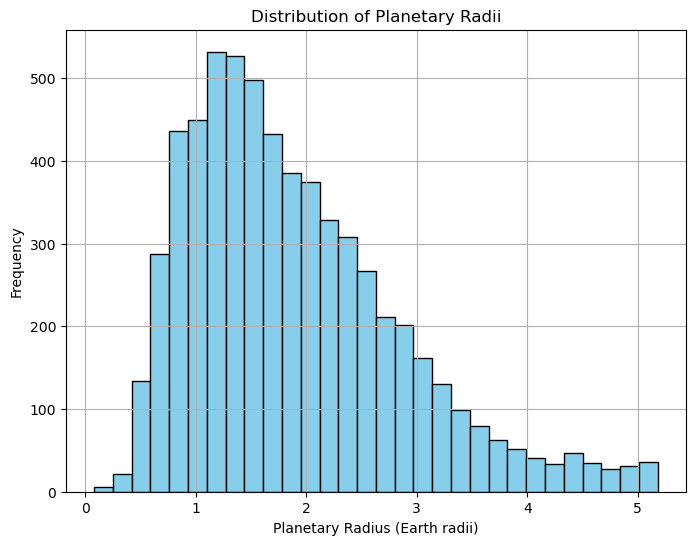

In [21]:
# plotting the histogram for the size of exoplanets which is our target
# x-axis is radius and y-axis is frequency
plt.figure(figsize=(8, 6))
plt.hist(df['koi_prad'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Planetary Radius (Earth radii)')
plt.ylabel('Frequency')
plt.title('Distribution of Planetary Radii')
plt.grid(True)
plt.show()

we can see that target is distributed acrossly from zero to a bit more than five. So this was acheived by removing outliers.

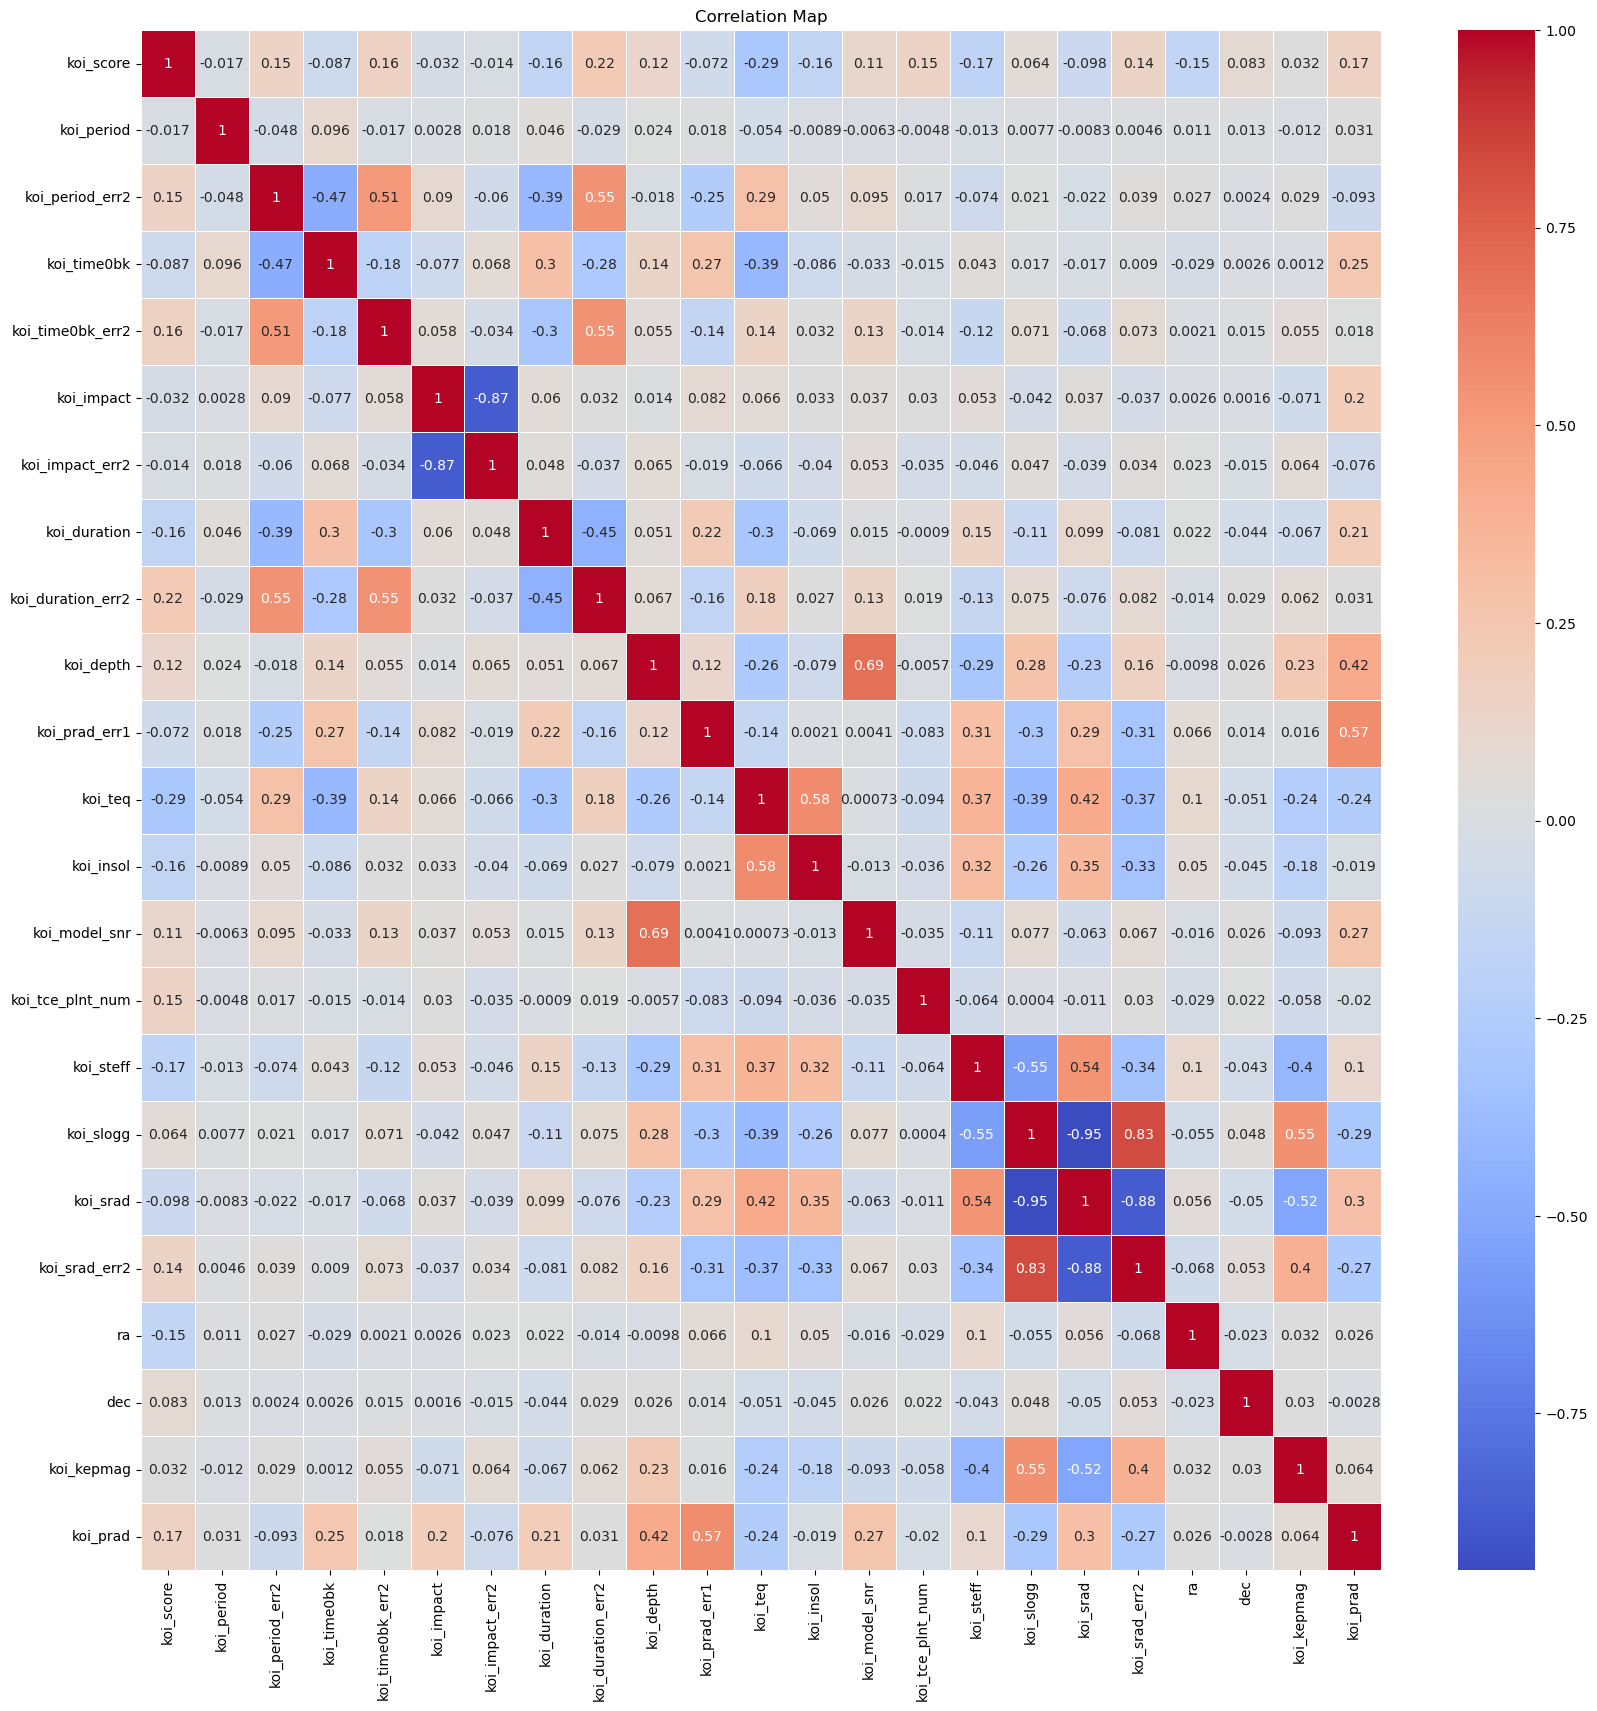

In [22]:
# generating correlation values for the dataframe columns 
correlation_matrix = df.drop(columns=['kepoi_name','koi_disposition','koi_pdisposition']).corr()

# Create a heatmap using seaborn
plt.figure(figsize=(20, 20))
heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map')
plt.show()

The above correlation heatmap shows that <br>
koi_slogg and koi_srad_err2 has the highest positive correlation <br>
koi_srad and koi_slogg has the highest negative correlation<br>
The below are scatter plots for these two highly correlated columns of dataframe

<h1>Data Vizualizations and Insights</h1>

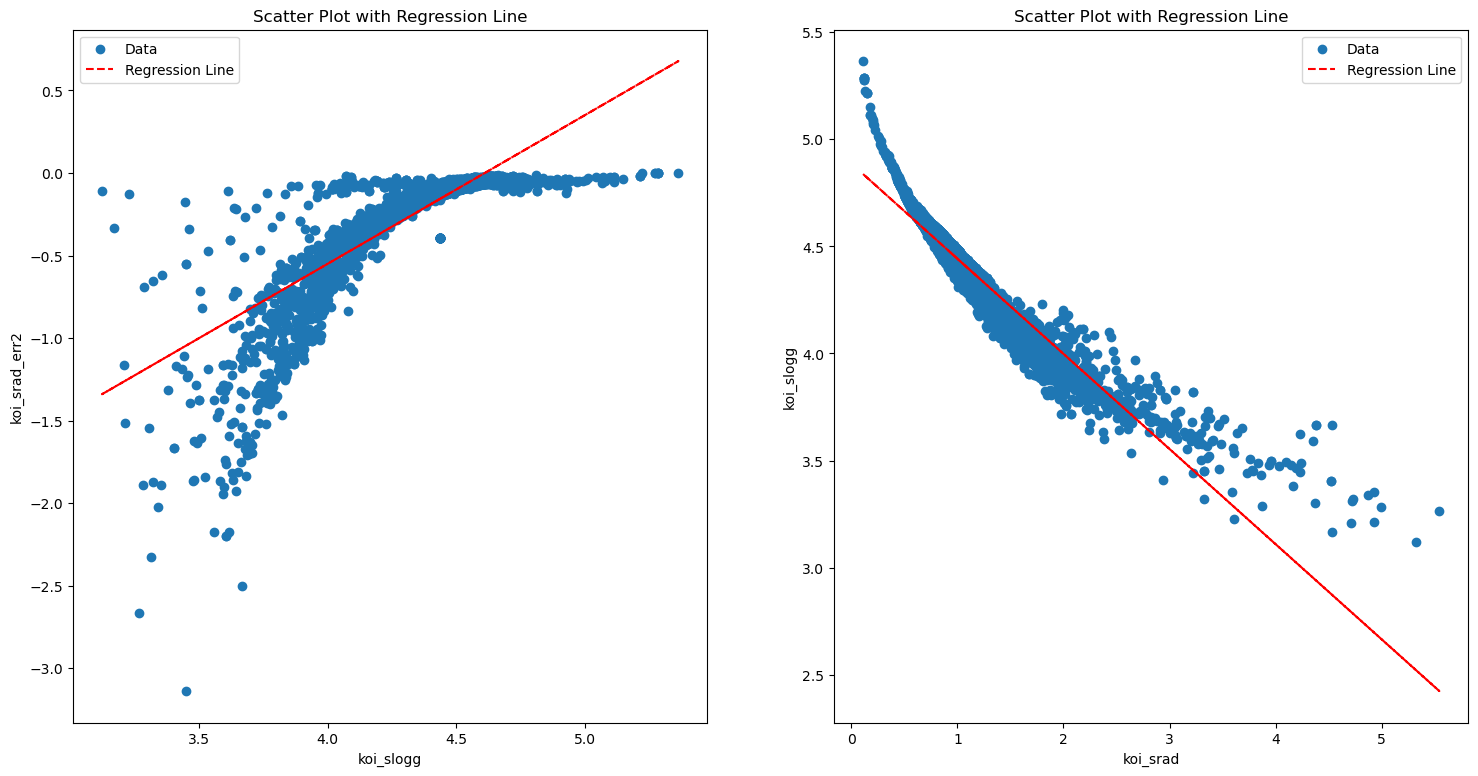

In [23]:
# making two subplots for displaying the above two correlated columns
fig, ax = plt.subplots(1,2, figsize=(18,9))

# positive correlated scatterplot
ax[0].scatter(df['koi_slogg'], df['koi_srad_err2'], label='Data')

# Calculating the line of best fit (linear regression)
coefficients = polyfit(df['koi_slogg'], df['koi_srad_err2'], 1)
poly = poly1d(coefficients)
ax[0].plot(df['koi_slogg'], poly(df['koi_slogg']), color='red', linestyle='--', label='Regression Line')

# giving names for axees and plot, and adding legend
ax[0].set_title('Scatter Plot with Regression Line')
ax[0].set_xlabel('koi_slogg')
ax[0].set_ylabel('koi_srad_err2')
ax[0].legend()

         
# negative correlated scatterplot
ax[1].scatter(df['koi_srad'], df['koi_slogg'], label='Data')

# Calculate the line of best fit (linear regression)
coefficients = polyfit(df['koi_srad'], df['koi_slogg'], 1)
poly = poly1d(coefficients)
ax[1].plot(df['koi_srad'], poly(df['koi_srad']), color='red', linestyle='--', label='Regression Line')

# giving names for axees and plot, and adding legend
ax[1].set_title('Scatter Plot with Regression Line')
ax[1].set_xlabel('koi_srad')
ax[1].set_ylabel('koi_slogg')
ax[1].legend()
plt.show()

koi_slogg vs koi_srad_err2<br>
The positive correlation suggests that there is a tendency for higher values of 'koi_slogg' to be associated with higher values of 'koi_srad_err2.'

koi_srad vs koi_slogg<br>
The negative correlation suggests that higher values of 'koi_srad' are associated with lower values of 'koi_slogg' This could indicate a certain relationship or pattern in the data.

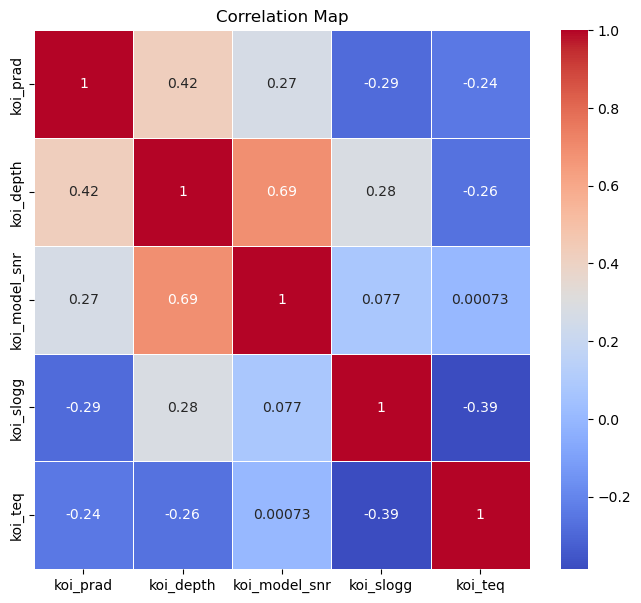

In [24]:
# creating heatmap for our target where the correlation is more
correlation_matrix = df[['koi_prad', 'koi_depth', 'koi_model_snr', 'koi_slogg', 'koi_teq']].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 7))
heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Map')
plt.show()

koi_prad' and 'koi_depth<br>planetary radius ('koi_prad') vs the depth of the transit ('koi_depth').<br>
A positive correlation would suggest that larger planetary radii are associated with deeper transits.

koi_prad' and 'koi_model_snr<br>planetary radius vs signal-to-noise ratio of the transit model<br>
might indicate that larger planets are associated with more significant and clearer signals.

koi_slogg' and 'koi_steff<br>surface gravity ('koi_slogg') vs stellar effective temperature ('koi_steff').
Positive correlation might imply that higher surface gravity is associated with higher stellar temperatures.

koi_teq' and 'koi_steff<br>
There might be a correlation between the equilibrium temperature of the planet ('koi_teq') and the stellar effective temperature ('koi_steff').
Positive correlation could suggest that planets with higher equilibrium temperatures are orbiting stars with higher temperatures.

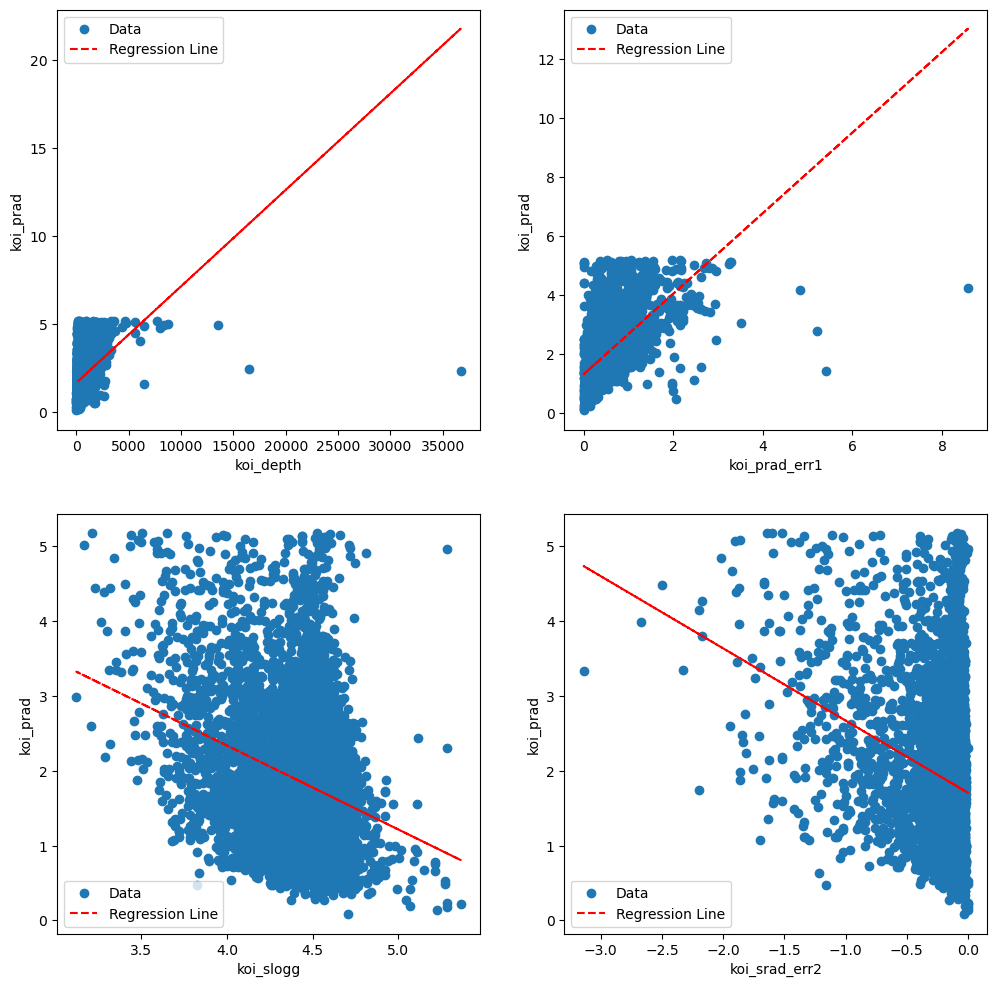

In [25]:
# scatter plots for highly correlated columns with our target
fig, ax = plt.subplots(2,2, figsize=(12,12))
column0 = 'koi_depth'
column1 = 'koi_prad_err1'
column2 = 'koi_slogg'
column3 = 'koi_srad_err2'
column = 'koi_prad'

ax[0,0].scatter(df[column0], df[column], label='Data')
ax[0,1].scatter(df[column1], df[column], label='Data')
ax[1,0].scatter(df[column2], df[column], label='Data')
ax[1,1].scatter(df[column3], df[column], label='Data')


# Calculating the line of best fit for all subplots (linear regression)
coefficients = polyfit(df[column0], df[column], 1)
poly = poly1d(coefficients)
ax[0,0].plot(df[column0], poly(df[column0]), color='red', linestyle='--', label='Regression Line')

coefficients = polyfit(df[column1], df[column], 1)
poly = poly1d(coefficients)
ax[0,1].plot(df[column1], poly(df[column1]), color='red', linestyle='--', label='Regression Line')

coefficients = polyfit(df[column2], df[column], 1)
poly = poly1d(coefficients)
ax[1,0].plot(df[column2], poly(df[column2]), color='red', linestyle='--', label='Regression Line')

coefficients = polyfit(df[column3], df[column], 1)
poly = poly1d(coefficients)
ax[1,1].plot(df[column3], poly(df[column3]), color='red', linestyle='--', label='Regression Line')

# giving names for axes and titles for all subplots
ax[0,0].set_xlabel(column0)
ax[0,1].set_xlabel(column1)
ax[1,0].set_xlabel(column2)
ax[1,1].set_xlabel(column3)
ax[0,0].set_ylabel(column)
ax[0,1].set_ylabel(column)
ax[1,0].set_ylabel(column)
ax[1,1].set_ylabel(column)
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()
plt.show()

From the first two scatterplots we can see positive correlation<br>
From the next two scatterplots we can see negative correlation 

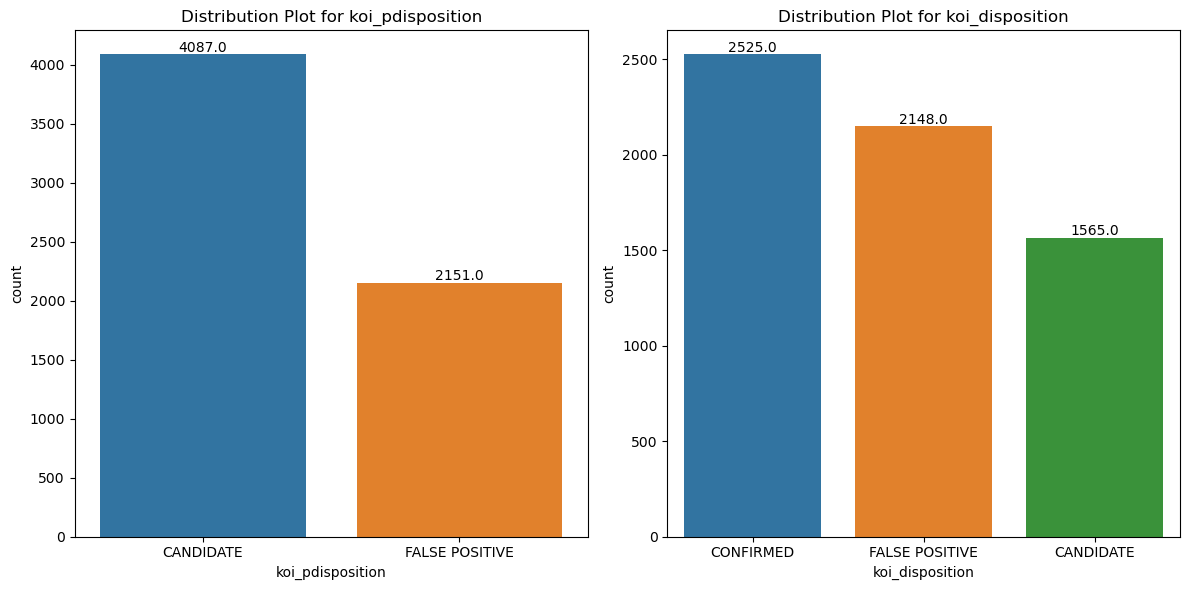

In [26]:
# Assuming df contains the DataFrame with the necessary columns

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot count plot for 'koi_disposition'
countplot(x='koi_pdisposition', data=df, ax=axes[0])
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='top', xytext=(0, 10), textcoords='offset points')
axes[0].set_title('Distribution Plot for koi_pdisposition')

# Plot count plot for 'koi_pdisposition'
countplot(x='koi_disposition', data=df, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='top', xytext=(0, 10), textcoords='offset points')
axes[1].set_title('Distribution Plot for koi_disposition')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

from the above two countplots<br>
koi_pdisposition - category exoplanet is comes under when it is discovered<br>
koi_disposition - category exoplanet is put under from research.

So from the above two countplots we can clearly see that after research after first discovery 2525 candidates are identified as confirmed exoplanets and three of FALSE POSITIVE category exoplanets are out of that category. 
Still there are 1565 exoplanets which are still considered as CANDIDATE which means there is still research needed to place this exoplanets in CONFIRMED or FALSE POSITIVE category.

In [27]:
# we are calculating the biggest exoplanets from the dataset
temp = read_csv('nasa_exoplanets.csv', skiprows=53)
biggest_exoplanets = temp.nlargest(10, 'koi_prad') 


# Set a new index starting from 1
biggest_exoplanets.index = range(1, len(biggest_exoplanets) + 1)

# Selecting the top 5 largest exoplanets based on 'koi_prad'
print("Largest Exoplaents till now")
print(biggest_exoplanets[['kepoi_name', 'koi_prad']]) # Displaying the names, radius of the biggest exoplanets

Largest Exoplaents till now
   kepoi_name  koi_prad
1   K06604.01  200346.0
2   K07251.01  161858.0
3   K05873.01  109061.0
4   K06704.01   64333.8
5   K05214.01   46743.4
6   K05681.01   28199.3
7   K03800.01   26042.9
8   K06200.01   15056.9
9   K00267.01   15049.8
10  K07231.02   13333.5


In [28]:
# exoplanets whose size is closest to the earth size

earth_radius = 1.0  # Earth's radius is 1 Earth radius

# Filter confirmed planets
confirmed_planets = df[df['koi_disposition'] == 'CONFIRMED']

# Define a threshold for closeness to Earth's radius
threshold = 0.01 

# Filter planets close to Earth's radius
close_to_earth = abs(confirmed_planets['koi_prad'] - earth_radius) < threshold

# Get the names of confirmed planets that satisfy the condition
close_planet_names = confirmed_planets[close_to_earth]

print('planets whose size is closest to the earth -')
print(close_planet_names.kepoi_name.to_string(index=False))

planets whose size is closest to the earth -
K00156.02
K01702.01
K02650.02
K02443.02
K02675.02
K02693.01
K00627.02
K04335.01
K01972.02
K03371.02


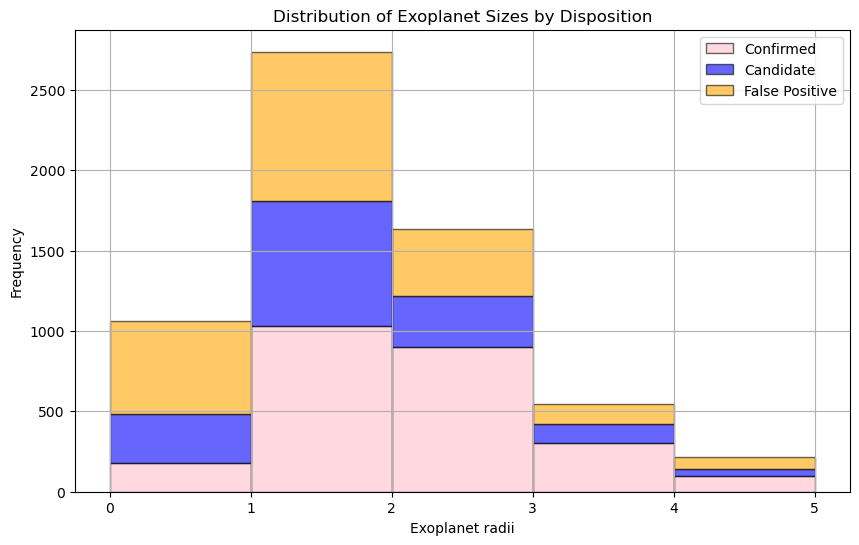

In [29]:
# seeing distribution of planets based on disposition

# Extracting data for each disposition
confirmed_sizes = df[df['koi_disposition'] == 'CONFIRMED']['koi_prad']
candidate_sizes = df[df['koi_disposition'] == 'CANDIDATE']['koi_prad']
false_positive_sizes = df[df['koi_disposition'] == 'FALSE POSITIVE']['koi_prad']

# Defining the intervals for the x-axis bins
intervals = [i for i in range(0, 6)]

# Plotting grouped histograms for each disposition within specific regions on the x-axis
plt.figure(figsize=(10, 6))
plt.hist([confirmed_sizes, candidate_sizes, false_positive_sizes], bins=intervals, stacked=True,
         color=['pink', 'blue', 'orange'], alpha=0.6, label=['Confirmed', 'Candidate', 'False Positive'], edgecolor='black')

# giving names to axes and also a title
plt.xlabel('Exoplanet radii')
plt.ylabel('Frequency')
plt.title('Distribution of Exoplanet Sizes by Disposition')
plt.legend()
plt.grid(True)
plt.show()

The histogram allows for a visual comparison of exoplanet sizes across different dispositions ('CONFIRMED,' 'CANDIDATE,' 'FALSE POSITIVE').
Stacked bars represent the frequency of exoplanet sizes within specific intervals for each disposition.
The height of the bars within each interval represents the frequency of exoplanets falling within that size range.

In [30]:
# we are calculating the biggest exoplanets from the dataset
temp = read_csv('nasa_exoplanets.csv', skiprows=53)
biggest_exoplanets = temp.nlargest(10, 'koi_period') 


# Set a new index starting from 1
biggest_exoplanets.index = range(1, len(biggest_exoplanets) + 1)

# Selecting the top 5 largest exoplanets based on 'koi_prad'
print("Exoplanets with highest orbital period (in days) are:\n")
print(biggest_exoplanets[['kepoi_name','koi_period', 'koi_prad']]) # Displaying the names, radius and period of the biggest exoplanets

Exoplanets with highest orbital period (in days) are:

   kepoi_name     koi_period  koi_prad
1   K01174.01  129995.778400      2.99
2   K00099.01    2190.701035      3.12
3   K01421.01    1693.663622     10.23
4   K01032.01    1500.140677     18.35
5   K01096.01    1500.000000      9.80
6   K01192.01    1295.362215     57.82
7   K00490.02    1071.232624      9.27
8   K01463.01    1064.268096     33.63
9   K00375.01     988.881118     10.81
10  K00435.02     934.094185      7.89


We can clearly see that there is no relation between period of a exoplanet and the planetary radius of the corresponding exoplanet. This can also be seen from the correlation heatmap, the correlation was only 0.031 which is very less.

<h1>Linear Regression Model</h1>

In [31]:
# selecting numerical columns for our model
numerical_columns = df.select_dtypes(include=['int', 'float']).columns

# preparing data
X=df[numerical_columns].drop(columns=['koi_prad'])

# use below X to check for comparing inbuild model and mathematical formula for prediciton
# this gives values considering only one feature vector like in mathematical model
# X = df.koi_prad_err1.values.reshape(-1, 1)

y=df['koi_prad']

# splitting data into 80-20 ratio for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# creating and training model
simple_lin_model = LinearRegression()
simple_lin_model.fit(X_train, y_train)

# model evaluation for training set
y_train_predict = simple_lin_model.predict(X_train)

# model evaluation for testing set    
y_test_predict = simple_lin_model.predict(X_test)

# finding mean and rmse 
mean = df['koi_prad'].describe()['mean']
train_rmse = sqrt(mean_squared_error(y_train, y_train_predict))
test_rmse = sqrt(mean_squared_error(y_test, y_test_predict))

# printing stats of the model
print('Mean of target   -', mean)
print('train rmse       -', train_rmse)
print('test rmse        -', test_rmse)
print('train r2 error   -', r2_score(y_train, y_train_predict))
print('test r2 error    -', r2_score(y_test, y_test_predict))
print('train accuracy   -', round((1-(train_rmse/mean))*100,2),'%')
print('test accuracy    -', round((1-(test_rmse/mean))*100,2),'%')

Mean of target   - 1.891729721064444
train rmse       - 0.5409757742066981
test rmse        - 0.6143167861325055
train r2 error   - 0.6744390989173539
test r2 error    - 0.6351517155680004
train accuracy   - 71.4 %
test accuracy    - 67.53 %


<h1>Linear Regression using Mathematical formulae</h1>

Unlike linear regression model here we are using only one column from the dataframe to predict<br>
So the formula will be y=mx+c, here we will find m and c, m is slope, c is intercept<br>
Also we are using whole dataframe to train and randomly selecting half of the dataframe to test<br>
so this accuracy can be considered as training accuracy

In [32]:
# Calculate mean of x and y

# selecting feature column
x = 'koi_prad_err1'  
mean_x = df[x].mean()
mean_y = df['koi_prad'].mean()

# Calculate slope and intercept
slope = sum((df[x] - mean_x) * (df['koi_prad'] - mean_y)) / sum((df[x] - mean_x)**2)
intercept = mean_y - slope * mean_x

# Define a function to predict y based on x
def predict(x):
  return slope * x + intercept

# making new dataframe randomly with half the size of original dataframe
temp_df =  df[['koi_prad', x]].copy()
random_rows = temp_df.sample(n=int(df.shape[0]/2))

y_test_predict = predict(random_rows[x])
y_test = random_rows['koi_prad']

mean = df['koi_prad'].describe()['mean']
test_rmse = sqrt(mean_squared_error(y_test, y_test_predict))

print('Target Mean -', mean)
print('RMSE        -', test_rmse)
print('R2 error    -', r2_score(y_test, y_test_predict))
print('Accuracy    -', round((1-(test_rmse/mean))*100, 2),'%')

Target Mean - 1.891729721064444
RMSE        - 0.7885044733413187
R2 error    - 0.329609769803594
Accuracy    - 58.32 %


<h1>Random Forest Classifier</h1>

We used random forest classifier to find the potential exoplanets.

In [33]:
# Selecting relevant columns for analysis 
features = ['koi_period', 'koi_depth', 'koi_duration', 'koi_impact', 'koi_model_snr',
            'koi_prad', 'koi_teq', 'koi_steff', 'koi_slogg', 'koi_srad', 'koi_insol']

# Combining confirmed and candidate planets
confirmed_exoplanets = df[df['koi_disposition'] == 'CONFIRMED'].copy()
candidate_planets = df[df['koi_disposition'] == 'CANDIDATE'].copy()

# Creating a new column 'confirmed' indicating confirmed (1) or not confirmed (0)
confirmed_exoplanets.loc[:, 'confirmed'] = 1
candidate_planets.loc[:, 'confirmed'] = 0

# Concatenating both datasets
combined_data = concat([confirmed_exoplanets, candidate_planets], ignore_index=True)

# Splitting data into features and target (confirmed or not)
X = combined_data[features]
y = combined_data['confirmed']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predicting on the test set
y_pred = clf.predict(X_test)

# Evaluating accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {round(accuracy*100,2)}%")

# Feature importance
feature_importance = DataFrame({'Feature': features, 'Importance': clf.feature_importances_})
print("Feature Importance:")
print(feature_importance)


Accuracy: 87.16%
Feature Importance:
          Feature  Importance
0      koi_period    0.085823
1       koi_depth    0.074126
2    koi_duration    0.061475
3      koi_impact    0.047550
4   koi_model_snr    0.427522
5        koi_prad    0.065585
6         koi_teq    0.049937
7       koi_steff    0.053437
8       koi_slogg    0.038899
9        koi_srad    0.040721
10      koi_insol    0.054926


In [34]:
# Calculate mean and standard deviation for confirmed exoplanets
confirmed_means = confirmed_exoplanets[features].mean()
confirmed_stds = confirmed_exoplanets[features].std()

# Filter candidate planets
candidate_planets = candidate_planets.reset_index(drop=True)  # Reset index for candidate planets
predictions = []  # To store predictions

# Compare candidate planets against confirmed exoplanets' statistics
for index, row in candidate_planets.iterrows():
    is_exoplanet = True  # Assume initially that it's an exoplanet
    
    # Check each feature against the range of confirmed exoplanets
    for feature in features:
        value = row[feature]
        mean = confirmed_means[feature]
        std = confirmed_stds[feature]
        
        if not (mean - std <= value <= mean + std):
            is_exoplanet = False  # If any feature is outside the range, it might not be an exoplanet
            break
    
    predictions.append(is_exoplanet)  # Store the prediction for this candidate planet

# Add predictions to the candidate planets DataFrame
candidate_planets['predicted_as_exoplanet'] = predictions

# Display candidate planets and their predicted status
display(candidate_planets[candidate_planets['predicted_as_exoplanet']==True])

print('potential exoplanet count -', len(candidate_planets[candidate_planets['predicted_as_exoplanet']==True]))


,kepoi_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_period_err2,koi_time0bk,koi_time0bk_err2,koi_impact,koi_impact_err2,...,koi_steff,koi_slogg,koi_srad,koi_srad_err2,ra,dec,koi_kepmag,koi_prad,confirmed,predicted_as_exoplanet
3,K00914.01,CANDIDATE,CANDIDATE,1.000000,3.886655,-0.000008,169.73814,-0.00155,0.6490,-0.4760,...,5662.0,4.610,0.738,-0.060,288.72665,44.607510,15.371,1.87,0,True
19,K01362.01,CANDIDATE,CANDIDATE,1.000000,20.513602,-0.000083,357.49424,-0.00310,0.7030,-0.5200,...,5310.0,4.608,0.704,-0.062,281.60541,42.390419,15.406,2.58,0,True
24,K01331.01,CANDIDATE,CANDIDATE,0.999000,6.800820,-0.000023,359.17999,-0.00243,0.5970,-0.4480,...,4805.0,4.633,0.688,-0.045,294.50842,39.398682,15.238,1.88,0,True
28,K01338.02,CANDIDATE,CANDIDATE,0.999000,42.037066,-0.000428,178.25006,-0.00748,0.6720,-0.5170,...,5823.0,4.427,0.960,-0.140,292.27612,39.550179,14.609,1.66,0,True
30,K01399.01,CANDIDATE,CANDIDATE,1.000000,8.750598,-0.000034,358.24233,-0.00278,0.3300,-0.3300,...,4942.0,4.599,0.779,-0.046,295.76083,45.457390,15.920,2.27,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1426,K06484.01,CANDIDATE,CANDIDATE,0.483768,16.119145,-0.000338,146.79780,-0.01810,0.6704,-0.4924,...,5319.0,4.514,0.783,-0.087,286.54742,40.150539,15.696,1.34,0,True
1427,K06601.01,CANDIDATE,CANDIDATE,0.968000,17.992597,-0.000172,135.45450,-0.00781,0.6780,-0.4630,...,5931.0,4.351,1.087,-0.202,283.13373,40.852421,14.604,1.62,0,True
1435,K07270.01,CANDIDATE,CANDIDATE,0.998000,19.253213,-0.000249,144.84070,-0.01180,0.2470,-0.2470,...,6060.0,4.495,0.953,-0.092,287.46475,46.968410,15.362,1.42,0,True
1453,K06751.01,CANDIDATE,CANDIDATE,0.267000,24.996068,-0.003803,144.96930,-0.02270,0.4090,-0.4090,...,5761.0,4.492,0.956,-0.048,281.64999,42.132061,15.183,2.40,0,True


potential exoplanet count - 101


From the above cell we can say that 101 exoplanets are having higher chances to be confirmed as exoplanets since those have the values which are similar to the confirmed exoplanets.

<h3>Finding important feature of exoplanets</h3>

In [35]:
# List of features and their importance
feature_importance = ['koi_period','koi_depth','koi_duration','koi_impact','koi_model_snr','koi_prad','koi_teq','koi_steff','koi_slogg','koi_srad','koi_insol']

# Choose the target planet with kepoi_name "K00156.02"
# we chose this exoplanet because it has the closest radius with earth.
target_planet = df[df['kepoi_name'] == 'K00156.02']

# Extract only the specific features from the target planet
target_features = target_planet[feature_importance]
display(target_features)


,koi_period,koi_depth,koi_duration,koi_impact,koi_model_snr,koi_prad,koi_teq,koi_steff,koi_slogg,koi_srad,koi_insol
783,5.188564,358.7,2.3683,0.179,56.4,1.0,586.0,3980.0,4.722,0.54,27.95


koi_period: Orbital period of the exoplanet around its host star (5.188564 days). koi_depth: Amount of light blocked when the exoplanet transits in front of its host star (358.7 parts per million). koi_duration: Duration of the transit event (2.3683 hours). koi_impact: Impact parameter or how centrally the exoplanet transits its host star (0.179). koi_model_snr: Signal-to-noise ratio of the transit detection (56.4). koi_prad: Radius of the exoplanet relative to Earth's radius (1.0 Earth radius). koi_teq: Equilibrium temperature of the exoplanet (586.0 K). koi_steff: Effective temperature of the host star (3980.0 K). koi_slogg: Surface gravity of the host star (4.722). koi_srad: Stellar radius of the host star (0.54 times the solar radius). koi_insol: Insolation flux or amount of energy received from the host star (27.95 Earth flux).

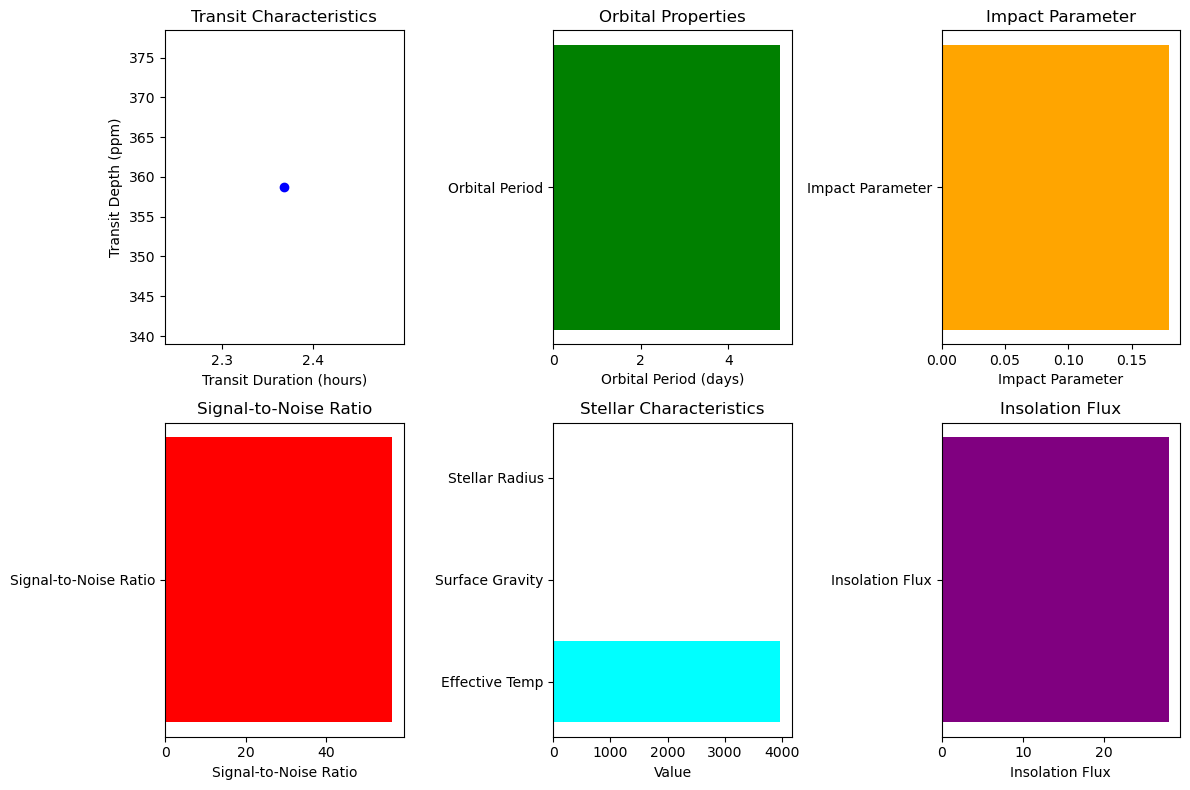

In [36]:
koi_depth = 358.7
koi_duration = 2.3683
koi_period = 5.188564
koi_impact = 0.179
koi_model_snr = 56.4
koi_steff = 3980.0
koi_slogg = 4.722
koi_srad = 0.54
koi_insol = 27.95


plt.figure(figsize=(12, 8))

# Transit Characteristics: Depth vs. Duration
plt.subplot(231)
plt.scatter(koi_duration, koi_depth, color='blue')
plt.xlabel('Transit Duration (hours)')
plt.ylabel('Transit Depth (ppm)')
plt.title('Transit Characteristics')

# Orbital Properties: Orbital Period
plt.subplot(232)
plt.barh('Orbital Period', koi_period, color='green')
plt.xlabel('Orbital Period (days)')
plt.title('Orbital Properties')

# Impact Parameter
plt.subplot(233)
plt.barh('Impact Parameter', koi_impact, color='orange')
plt.xlabel('Impact Parameter')
plt.title('Impact Parameter')

# Signal-to-Noise Ratio
plt.subplot(234)
plt.barh('Signal-to-Noise Ratio', koi_model_snr, color='red')
plt.xlabel('Signal-to-Noise Ratio')
plt.title('Signal-to-Noise Ratio')

# Stellar Characteristics: Effective Temperature, Surface Gravity, Stellar Radius
plt.subplot(235)
labels = ['Effective Temp', 'Surface Gravity', 'Stellar Radius']
values = [koi_steff, koi_slogg, koi_srad]
plt.barh(labels, values, color=['cyan', 'magenta', 'yellow'])
plt.xlabel('Value')
plt.title('Stellar Characteristics')

# Insolation Flux
plt.subplot(236)
plt.barh('Insolation Flux', koi_insol, color='purple')
plt.xlabel('Insolation Flux')
plt.title('Insolation Flux')

plt.tight_layout()
plt.show()


The observed transit characteristics (depth and duration) and the high SNR support the existence of a planet orbiting the host star. The relatively short orbital period and impact parameter suggest a close-in planet with consistent and reliable transits. Stellar characteristics hint at the nature of the host star, which influences the conditions of the exoplanet.

The combination of observed transit properties, orbital characteristics, reliable transit signals, and host star's features collectively contribute to confirming this exoplanet's existence and properties as an exoplanet within its system.